In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.spatial import cKDTree
from sklearn import model_selection
import seaborn as sns
import squidpy as sq
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import TruncatedSVD
# from utils import split_train_test
from scipy.stats import spearmanr, pearsonr
# import wandb
# import gensim
# from gensim.models import word2vec



In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
sc.set_figure_params(dpi=100, frameon=False, facecolor=None, transparent=True)

In [4]:
# adata_rna = sc.read('/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/V11L12-038_A1.RNA_MOSCOT_paired_hvg.h5ad')
# adata_msi = sc.read('/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/V11L12-038_A1.MSI_MOSCOT_paired_hvg.h5ad')

# adata_rna = sc.read('/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/V11T16-085_A1.RNA_MOSCOT.h5ad')
# adata_msi = sc.read('/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/V11T16-085_A1.MSI_MOSCOT.h5ad')

adata_rna = sc.read('/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/RNA_concat_neurotransmitters.h5ad')
adata_msi = sc.read('/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/MSI_concat_neurotransmitters.h5ad')

# adata_rna = sc.read('/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/RNA_concat_lipids.h5ad')
# adata_msi = sc.read('/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/MSI_concat_lipids.h5ad')




/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/scRNA-env/lib/python3.12/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/scRNA-env/lib/python3.12/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
adata_rna
adata_msi

AnnData object with n_obs × n_vars = 5443 × 1538
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide', 'msi_concat_clusters'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'spatialy_highly_variable', 'msi_highly_variable'
    uns: 'hvg', 'msi_concat_clusters', 'neighbors', 'pca', 'slide_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [142]:
top_genes =5000
split_name = "split"
n_components = 16
n_neighbors = 6



In [143]:
#----------------------------------------------sc-seqRNA----------------------------------------------#
#-----HVG-----#
if "highly_variable" not in adata_rna.var.columns:
    sc.pp.highly_variable_genes(adata_rna, flavor='seurat', n_top_genes=top_genes)
hvg_rna = adata_rna[:, adata_rna.var["highly_variable"]]


#split train and test, used for svd and rest
hvg_rna_train = hvg_rna[hvg_rna.obs[split_name] == "train"]
hvg_rna_test = hvg_rna[hvg_rna.obs[split_name] == "test"]

#-----SVD-----#
svd_reducer = TruncatedSVD(n_components=n_components) 

svd_features_train = svd_reducer.fit_transform(hvg_rna_train.X.toarray())
hvg_rna_train.obsm["svd_features"] = svd_features_train

svd_features_test = svd_reducer.fit_transform(hvg_rna_test.X.toarray())
hvg_rna_test.obsm["svd_features"] = svd_features_test



In [145]:
#-----GRAPH-----#
##Check if og data has spatial connectivities obsp else do the process here:


graph_feat_train = svd_reducer.fit_transform(hvg_rna_train[hvg_rna_train.obs_names].obsp["spatial_connectivities"])
graph_feat_test = svd_reducer.fit_transform(hvg_rna_test[hvg_rna_test.obs_names].obsp["spatial_connectivities"])


sc_svd = StandardScaler()
sc_gr = StandardScaler()

#Concatentate the features 
rna_hsg_train = np.concatenate([sc_svd.fit_transform(svd_features_train), \
                                        sc_gr.fit_transform(graph_feat_train)],
                                        axis=1)

rna_hsg_test = np.concatenate([sc_svd.fit_transform(svd_features_test), \
                                        sc_gr.fit_transform(graph_feat_test)],
                                        axis=1)



In [146]:
#----------------------------------------------MSI----------------------------------------------#
#-----HVG-----#
#MSI processed only for highly variable metabolites, kept hvg_ for uniformality in vars
if "highly_variable" not in adata_msi.var.columns:
    sc.pp.highly_variable_genes(adata_msi, flavor='seurat', n_top_genes=top_genes)
hvg_msi = adata_msi[:, adata_msi.var["highly_variable"]]

hvg_msi_train = hvg_msi[hvg_msi.obs[split_name] == "train"]
hvg_msi_test = hvg_msi[hvg_msi.obs[split_name] == "test"]



In [150]:
#----------------------------------------------SAVE----------------------------------------------#
rna_hsg_train
rna_hsg_test.shape
# hvg_msi_train
# hvg_msi_test

(537, 32)

In [40]:
hvg_rna_test

View of AnnData object with n_obs × n_vars = 2808 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'mt_frac', 'total_counts', 'n_counts', 'clusters', 'technology', 'random_split', 'half_split', 'og_index', 'slide', 'gex_concat_clusters'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'spatialy_highly_variable', 'gex_highly_variable'
    uns: 'gex_concat_clusters', 'hvg', 'neighbors', 'pca', 'slide_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [28]:
adata_msi.obsm["spatial_warp"]

array([[ 0., 49.],
       [ 0., 50.],
       [ 0., 51.],
       ...,
       [74., 23.],
       [74., 24.],
       [74., 25.]])

In [24]:
adata_rna

AnnData object with n_obs × n_vars = 5618 × 14196
    obs: 'in_tissue', 'array_row', 'array_col', 'mt_frac', 'total_counts', 'n_counts', 'clusters', 'technology', 'random_split', 'half_split', 'og_index', 'slide', 'gex_concat_clusters'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'spatialy_highly_variable', 'gex_highly_variable'
    uns: 'gex_concat_clusters', 'hvg', 'neighbors', 'pca', 'slide_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [5]:
top_genes = 5000
n_components = 16
n_neighbors = 6
split_name = "split"


In [6]:
#----------------------------------------------sc-seqRNA----------------------------------------------#
#-----HVG-----#
if "highly_variable" not in adata_rna.var.columns:
    sc.pp.highly_variable_genes(adata_rna, flavor='seurat', n_top_genes=top_genes)
hvg_rna = adata_rna[:, adata_rna.var["highly_variable"]].copy()

In [7]:
#split train and test, used for svd and rest
hvg_rna_train = hvg_rna[hvg_rna.obs["split"] == "train"].copy()
hvg_rna_test = hvg_rna[hvg_rna.obs["split"] == "test"].copy()

In [8]:
#-----SVD-----#
svd_reducer = TruncatedSVD(n_components=n_components) 


In [9]:

svd_features_train = svd_reducer.fit_transform(hvg_rna_train.X.toarray())
hvg_rna_train.obsm["svd_features"] = svd_features_train
svd_features_test = svd_reducer.fit_transform(hvg_rna_test.X.toarray())
hvg_rna_test.obsm["svd_features"] = svd_features_test


In [10]:
print(id(hvg_rna_train))
print(id(hvg_rna_train[hvg_rna_train.obs_names]))


140267759792400
140267759783040


In [11]:
hvg_rna_train[hvg_rna_train.obs_names].X == hvg_rna_train.X

/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/scRNA-env/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


<Compressed Sparse Row sparse matrix of dtype 'bool'
	with 4288000 stored elements and shape (2144, 2000)>

In [21]:
hvg_rna_train.obs_names

Index(['TTGTTTGTGTAAATTC-1', 'AACTGGTGTGGGCCTT-1', 'CATAATGAGCGGGCGA-1',
       'CATAATGAGCGGGCGA-1-1', 'ACGTTCCGCGCTCCGT-1', 'TTGTTTGTGTAAATTC-1-1',
       'TTGTTTGTGTAAATTC-1-2', 'AACTGGTGTGGGCCTT-1-1', 'ATCCTGCTGCAGATAG-1-1',
       'CCATCTTGTTCACAAT-1',
       ...
       'AGTAAGGGACAGAATC-1-2', 'AGTAAGGGACAGAATC-1-3', 'GGCGCACAGTTTACCT-1-1',
       'TCCCAATATCGACGAC-1-1', 'ACCTCAGCGAGGCGCA-1-1', 'ACATACAATCAAGCGG-1-1',
       'ACATACAATCAAGCGG-1-2', 'CCTGATTCGCGAAGAA-1-3', 'CCTGATTCGCGAAGAA-1-4',
       'CCCTACCCACACCCAG-1-2'],
      dtype='object', length=2144)

In [ ]:
#-----GRAPH-----#
##Check if og data has spatial connectivities obsp else do the process here:
graph_feat_train = svd_reducer.fit_transform(hvg_rna_train[hvg_rna_train.obs_names].obsp["spatial_connectivities"])
graph_feat_test = svd_reducer.fit_transform(hvg_rna_test[hvg_rna_test.obs_names].obsp["spatial_connectivities"])


In [13]:
sc_svd = StandardScaler()
sc_gr = StandardScaler()


In [14]:
#Concatentate the features 
rna_hsg_train = np.concatenate([sc_svd.fit_transform(svd_features_train), \
                                        sc_gr.fit_transform(graph_feat_train)],
                                        axis=1)

rna_hsg_test = np.concatenate([sc_svd.fit_transform(svd_features_test), \
                                        sc_gr.fit_transform(graph_feat_test)],
                                        axis=1)


In [15]:
sc_gr.fit_transform(graph_feat_train).shape

(2144, 16)

In [16]:
rna_hsg_test

array([[ 8.48393083e-01,  1.01880682e+00,  3.84495527e-01, ...,
        -1.18630364e-01,  2.54192128e-02,  4.00358101e-02],
       [ 1.65586278e-01,  6.04808748e-01,  7.77338028e-01, ...,
        -3.80814728e-02, -1.74471536e-02,  2.66493856e-02],
       [ 1.65586278e-01,  6.04808748e-01,  7.77338028e-01, ...,
        -3.80814728e-02, -1.74471536e-02,  2.66493856e-02],
       ...,
       [ 1.14196920e+00, -1.98200911e-01, -5.09996235e-01, ...,
        -7.76572654e-02, -2.58217726e-01,  2.02373413e-01],
       [-1.09946620e+00, -9.05725598e-01, -1.14390409e+00, ...,
        -4.69346015e-02, -1.36159085e-01, -3.46068411e-01],
       [ 6.35273987e-04, -6.17296040e-01, -8.15086484e-01, ...,
        -3.94522118e-01,  6.29129709e-01, -6.30386747e-01]])

In [17]:
#----------------------------------------------MSI----------------------------------------------#
#-----HVG-----#
#MSI processed only for highly variable metabolites, kept hvg_ for uniformality in vars
if "highly_variable" not in adata_msi.var.columns:
    sc.pp.highly_variable_genes(adata_msi, flavor='seurat', n_top_genes=top_genes)
hvg_msi = adata_msi[:, adata_msi.var["highly_variable"]].copy()

hvg_msi_train = hvg_msi[hvg_msi.obs["split"] == "train"].copy()
hvg_msi_test = hvg_msi[hvg_msi.obs["split"] == "test"].copy()


In [18]:
hvg_msi_train.X.shape

(2144, 500)

In [19]:
adata_rna.X.shape

(2681, 2000)

In [20]:
rna_hsg_train.shape #left only with 16 from svd and

(2144, 32)

In [ ]:
adata_msi_full = sc.read('/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/V11L12-038_A1.MSI_MOSCOT_paired_hvg.h5ad')
adata_rna_full = sc.read('/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/V11L12-038_A1.RNA_MOSCOT_paired_hvg.h5ad')

In [22]:
adata_rna_full

AnnData object with n_obs × n_vars = 2681 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'mt_frac', 'total_counts', 'n_counts', 'n_genes', 'clusters', 'technology', 'split'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'technology'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'raw_counts', 'spatial', 'spatial_warp'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [16]:
train_idx = np.where(adata_msi_full.obs["split"] == 'train')[0]


In [17]:
train_idx



array([   0,    1,    2, ..., 2678, 2679, 2680])

In [18]:
adata_msi_train = adata_msi_full[np.where(adata_msi_full.obs["split"] == 'train')[0]]

In [19]:
adata_msi_train

View of AnnData object with n_obs × n_vars = 2144 × 500
    obs: 'technology', 'clusters', 'split', 'og_index'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'raw_counts', 'spatial', 'spatial_warp'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [6]:
adata_rna_full

AnnData object with n_obs × n_vars = 2681 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'mt_frac', 'total_counts', 'n_counts', 'n_genes', 'clusters', 'technology', 'split'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'technology'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'raw_counts', 'spatial', 'spatial_warp'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [14]:
adata_msi_full.obs["train"]

KeyError: 'train'

In [ ]:
msi_train = adata_msi[:, adata_msi.obs["train"]adata_msi_train].copy()
msi_test = adata_msi[:, adata_msi.obs["test"]].copy()



In [6]:
adata_msi_full

AnnData object with n_obs × n_vars = 2681 × 500
    obs: 'technology', 'clusters', 'split', 'og_index'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'raw_counts', 'spatial', 'spatial_warp'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [7]:
adata_msi_full.obs

,technology,clusters,split,og_index
TTGTTTGTGTAAATTC-1,MSI,1,train,49
AACTGGTGTGGGCCTT-1,MSI,1,train,50
CATAATGAGCGGGCGA-1,MSI,2,train,51
CATAATGAGCGGGCGA-1-1,MSI,2,train,52
ATCCTGCTGCAGATAG-1,MSI,4,test,53
...,...,...,...,...
ACATACAATCAAGCGG-1-1,MSI,1,train,4793
ACATACAATCAAGCGG-1-2,MSI,1,train,4794
CCTGATTCGCGAAGAA-1-3,MSI,1,train,4795
CCTGATTCGCGAAGAA-1-4,MSI,1,train,4796


In [8]:
adata_msi_full.X.shape

(2681, 500)

In [9]:
adata_msi_full.var

,highly_variable,means,dispersions,dispersions_norm
137.023795,True,16.457432,16.244787,1.111899
154.026815,True,12.282051,12.890668,1.498388
162.11293999999998,True,13.661283,13.783248,0.685038
169.07619,True,13.470905,15.882873,5.257481
169.076575,True,13.558031,15.862571,5.213268
...,...,...,...,...
981.582135,True,8.348629,11.216965,0.650746
982.519885,True,8.086034,11.228839,0.684927
983.879985,True,8.370474,11.189914,0.572880
985.53971,True,7.986569,11.179927,0.625368


In [10]:
adata_msi_full.obsp["distances"]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 10671 stored elements and shape (2681, 2681)>

In [11]:
adata_rna_full.obsp["distances"]


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 254896 stored elements and shape (2681, 2681)>

In [12]:
from scipy.sparse import issparse

# Ensure both are sparse matrices
conn_msi = adata_msi_full.obsm["spatial"]
conn_rna = adata_rna_full.obsm["spatial"]

if issparse(conn_msi) and issparse(conn_rna):
    matrices_equal = (conn_msi != conn_rna) == 0  # Check if all elements are the same
    print("Matrices are identical:", matrices_equal)
else:
    matrices_equal = np.allclose(conn_msi, conn_rna, atol=1e-8)  # Use atol for floating-point precision issues
    print("MAts are identical:", matrices_equal)

MAts are identical: False


In [13]:
adata_msi_full.varm

AxisArrays with keys: PCs

In [14]:
adata_msi_full.obsp

PairwiseArrays with keys: connectivities, distances, spatial_connectivities, spatial_distances

In [15]:
adata_rna_full

AnnData object with n_obs × n_vars = 2681 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'mt_frac', 'total_counts', 'n_counts', 'n_genes', 'clusters', 'technology', 'split'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'technology'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'raw_counts', 'spatial', 'spatial_warp'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [16]:
adata_rna_full.obs

,in_tissue,array_row,array_col,mt_frac,total_counts,n_counts,n_genes,clusters,technology,split
TTGTTTGTGTAAATTC-1,1,7,51,0.0,17407.0,17407.0,5044,2,RNA,train
AACTGGTGTGGGCCTT-1,1,7,49,0.0,13106.0,13106.0,4762,2,RNA,train
CATAATGAGCGGGCGA-1,1,6,46,0.0,4437.0,4437.0,1931,2,RNA,train
CATAATGAGCGGGCGA-1-1,1,6,46,0.0,4437.0,4437.0,1931,2,RNA,train
ATCCTGCTGCAGATAG-1,1,6,44,0.0,4443.0,4443.0,1847,3,RNA,test
...,...,...,...,...,...,...,...,...,...,...
ACATACAATCAAGCGG-1-1,1,76,96,0.0,2686.0,2686.0,1545,5,RNA,train
ACATACAATCAAGCGG-1-2,1,76,96,0.0,2686.0,2686.0,1545,5,RNA,train
CCTGATTCGCGAAGAA-1-3,1,75,93,0.0,2143.0,2143.0,1299,4,RNA,train
CCTGATTCGCGAAGAA-1-4,1,75,93,0.0,2143.0,2143.0,1299,4,RNA,train


In [17]:
adata_rna_full.obsm

AxisArrays with keys: X_pca, X_umap, raw_counts, spatial, spatial_warp

In [18]:
adata_rna_full.obsp

PairwiseArrays with keys: connectivities, distances, spatial_connectivities, spatial_distances

In [19]:
adata_rna_full.var

,gene_ids,feature_types,genome,n_cells,highly_variable,means,dispersions,dispersions_norm,technology
Xkr4,ENSMUSG00000051951,Gene Expression,mm10,50,True,0.019306,0.230532,0.859532,RNA
Rb1cc1,ENSMUSG00000025907,Gene Expression,mm10,859,True,0.328914,0.302558,1.018156,RNA
Vxn,ENSMUSG00000067879,Gene Expression,mm10,970,True,0.504810,0.702096,3.957814,RNA
Prex2,ENSMUSG00000048960,Gene Expression,mm10,505,True,0.209376,0.409732,2.326602,RNA
Crispld1,ENSMUSG00000025776,Gene Expression,mm10,48,True,0.016889,0.237673,0.917995,RNA
...,...,...,...,...,...,...,...,...,...
Arhgap6,ENSMUSG00000031355,Gene Expression,mm10,222,True,0.085039,0.318518,1.579852,RNA
Gm15247,ENSMUSG00000086695,Gene Expression,mm10,10,True,0.003610,0.252237,1.037228,RNA
Uty,ENSMUSG00000068457,Gene Expression,mm10,140,True,0.052502,0.282789,1.287349,RNA
mt-Co2,ENSMUSG00000064354,Gene Expression,mm10,2686,True,3.761604,1.649854,1.000000,RNA


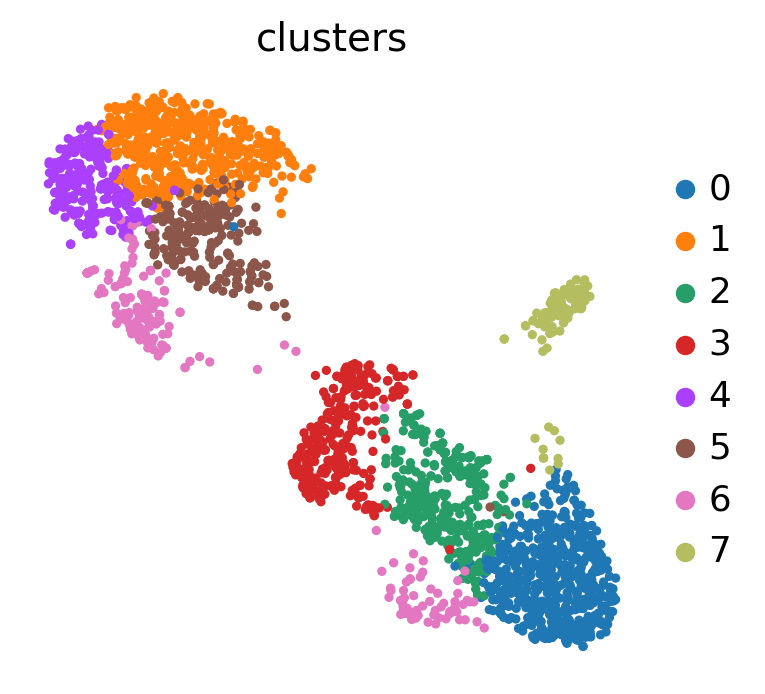

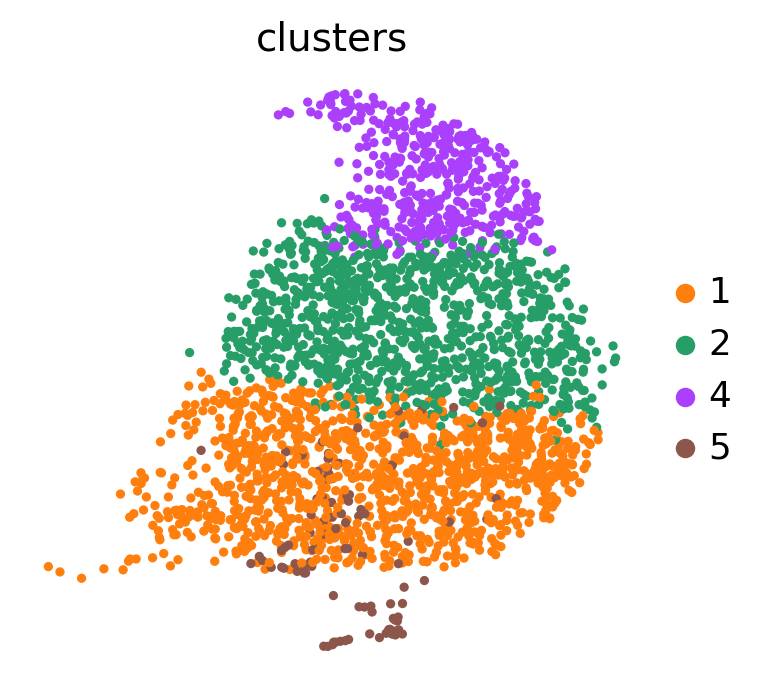

In [20]:
sc.pl.umap(adata_rna_full, color='clusters')
sc.pl.umap(adata_msi_full, color='clusters')


In [21]:
adata_msi_train = adata_msi_full[adata_msi_full.obs["split"] == "train"].copy()
adata_msi_test = adata_msi_full[adata_msi_full.obs["split"] == "test"].copy()

adata_rna_train = adata_rna_full[adata_rna_full.obs["split"] == "train"].copy()
adata_rna_test = adata_rna_full[adata_rna_full.obs["split"] == "test"].copy()


In [22]:
svd_reducer = TruncatedSVD(n_components=16)


In [23]:
svd_features_train = svd_reducer.fit_transform(adata_rna_train.X.toarray())
svd_features_test = svd_reducer.fit_transform(adata_rna_test.X.toarray())

adata_rna_train.obsm["svd_features"] = svd_features_train
adata_rna_test.obsm["svd_features"] = svd_features_test

In [24]:
sc.pp.neighbors(adata_rna_train, use_rep="svd_features", key_added="svd") 
#Uses SVD-reduced features to build a graph of nearest neighbors
sc.tl.leiden(adata_rna_train, neighbors_key="svd", key_added="svd_clust") 
#Runs Leiden clustering on the k-NN graph, storing results in adata_rna_train.obs["svd_clust"]

/tmp/ipykernel_678642/3737312483.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_rna_train, neighbors_key="svd", key_added="svd_clust")


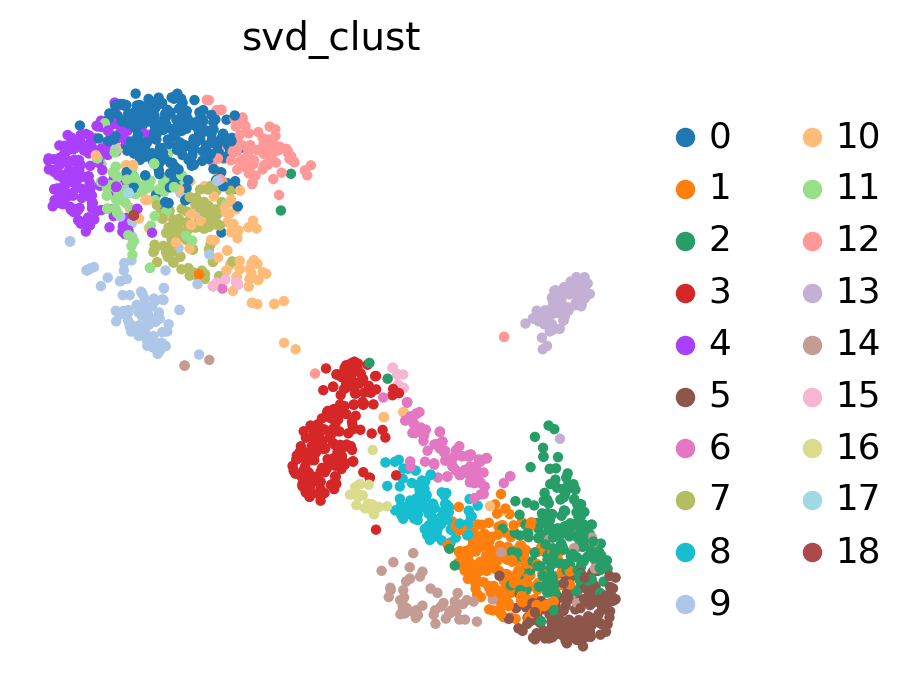

In [25]:
sc.pl.umap(adata_rna_train, color="svd_clust")


In [26]:
sc.pp.neighbors(adata_rna_test, use_rep="svd_features", key_added="svd")
sc.tl.leiden(adata_rna_test, neighbors_key="svd", key_added="svd_clust", resolution=2.7)


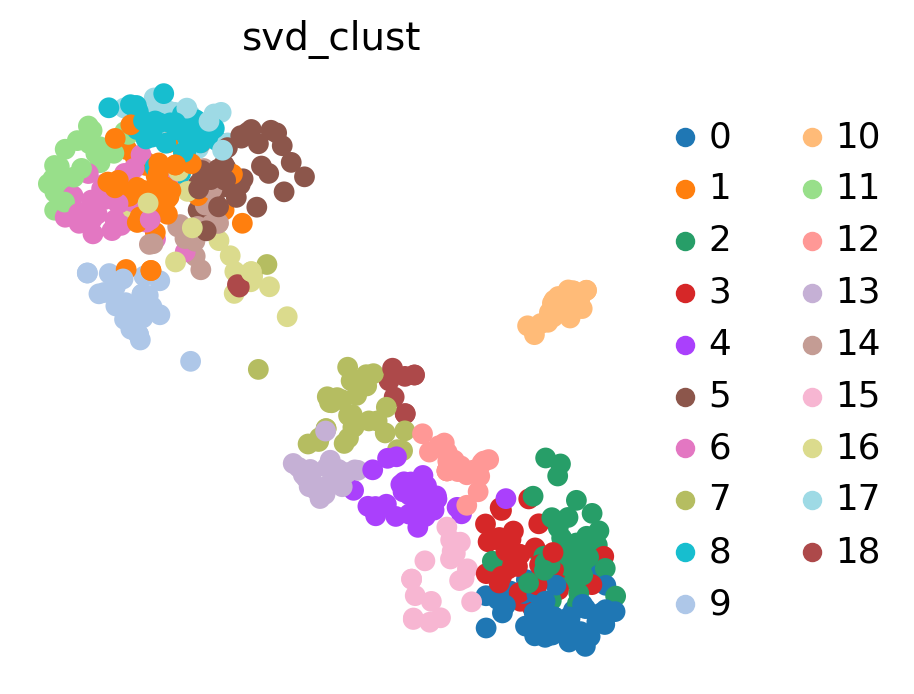

In [27]:
sc.pl.umap(adata_rna_test, color="svd_clust")


### "pseudobulk" svd
Storing train data in a DataFrame for pseudobulking



In [28]:
adata_df = pd.DataFrame(adata_rna_train.X.toarray(), columns = adata_rna_train.var_names)
adata_df["svd_clust"] = adata_rna_train.obs["svd_clust"].tolist().copy()
#since obs are kept in the same order I can just add it straigt away

In [29]:
adata_df

,Xkr4,Rb1cc1,Vxn,Prex2,Crispld1,Paqr8,Tram2,Kcnq5,Rims1,Phf3,...,Adgrg2,Txlng,Ace2,Tlr7,Arhgap6,Gm15247,Uty,mt-Co2,mt-Atp6,svd_clust
0,0.192634,0.192634,0.192634,0.354087,0.0,0.192634,0.0,0.192634,0.000000,0.192634,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.688655,4.803021,6
1,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.248201,0.000000,0.248201,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.895359,3.740778,6
2,0.000000,0.000000,0.000000,0.606506,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.648396,4.876004,10
3,0.000000,0.000000,0.000000,0.606506,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.648396,4.876004,10
4,0.000000,0.000000,0.000000,0.000000,0.0,0.314023,0.0,0.169287,0.440434,0.169287,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.675155,4.807090,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2139,0.000000,0.000000,0.000000,0.000000,0.0,0.865861,0.0,0.000000,0.865861,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.642323,3.711974,10
2140,0.000000,0.000000,0.000000,0.000000,0.0,0.865861,0.0,0.000000,0.865861,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.642323,3.711974,10
2141,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.492332,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.143994,4.116276,18
2142,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.492332,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.143994,4.116276,18


In [30]:
#For every cluster I aggregate count of genes using the mean expression within each cluster
pseudobulk_train = adata_df.groupby("svd_clust").mean().sort_index()

In [31]:
pseudobulk_train

,Xkr4,Rb1cc1,Vxn,Prex2,Crispld1,Paqr8,Tram2,Kcnq5,Rims1,Phf3,...,Ptchd1,Adgrg2,Txlng,Ace2,Tlr7,Arhgap6,Gm15247,Uty,mt-Co2,mt-Atp6
svd_clust,,,,,,,,,,,,,,,,,,,,,
0,0.007758,0.245513,0.778625,0.105267,0.005364,0.216488,0.006886,0.164444,0.391102,0.108485,...,0.003877,0.003620,0.070268,0.000000,0.010197,0.015160,0.000000,0.036692,3.663596,3.396520
1,0.002954,0.223794,0.077223,0.191009,0.022396,0.102194,0.008738,0.231526,0.178215,0.173971,...,0.002445,0.013058,0.106760,0.006967,0.005959,0.104093,0.000000,0.020189,3.813277,3.583089
10,0.018169,0.206140,0.287213,0.371251,0.012040,0.183840,0.000000,0.081748,0.332139,0.191339,...,0.000000,0.000000,0.044078,0.022568,0.008513,0.028968,0.000000,0.015615,4.046166,3.805168
11,0.008343,0.377971,0.490843,0.259658,0.000000,0.109543,0.000000,0.209186,0.458972,0.264653,...,0.010356,0.000000,0.058076,0.007568,0.000000,0.030327,0.000000,0.050942,3.721398,3.571835
12,0.017307,0.290225,0.969278,0.238848,0.000000,0.167515,0.000000,0.056389,0.353871,0.155859,...,0.000000,0.017736,0.083423,0.033210,0.041019,0.000000,0.000000,0.025266,3.551368,3.228448
13,0.021779,0.208879,0.128542,0.115956,0.000000,0.091998,0.012526,0.000000,0.105925,0.237687,...,0.000000,0.011751,0.009483,0.000000,0.008524,0.050224,0.000000,0.010890,3.225595,3.187855
14,0.000000,0.130187,0.082250,0.129856,0.000000,0.122127,0.000000,0.175907,0.237472,0.176232,...,0.000000,0.010961,0.075388,0.000000,0.011306,0.172346,0.005208,0.048631,3.783693,3.512550
15,0.000000,0.048710,0.124609,0.000000,0.018191,0.284133,0.000000,0.038069,0.141558,0.176243,...,0.000000,0.000000,0.098443,0.000000,0.000000,0.000000,0.000000,0.000000,4.274281,4.363296
16,0.000000,0.145327,0.176089,0.117750,0.000000,0.108662,0.000000,0.024191,0.059248,0.133593,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.053106,0.000000,0.027661,3.560819,3.411069


In [32]:
svd_reducer = TruncatedSVD(n_components=16)
svd_pseudobulk_train = svd_reducer.fit_transform(pseudobulk_train)
svd_pseudobulk_train = pd.DataFrame(svd_pseudobulk_train, index=pseudobulk_train.index)
svd_pseudobulk_feature_train = np.array([svd_pseudobulk_train.loc[clust].tolist() for clust in adata_rna_train.obs.svd_clust])


In [33]:
adata_rna_train.obsm["svd_pseudobulk_feature"] = svd_pseudobulk_feature_train


Test set

In [34]:
adata_df = pd.DataFrame(adata_rna_test.X.toarray(), columns = adata_rna_test.var_names)
adata_df["svd_clust"] = adata_rna_test.obs["svd_clust"].tolist().copy()
pseudobulk_test = adata_df.groupby("svd_clust").mean().sort_index()


In [35]:
#Keeping same SVDSolver to have a "shared" latent
svd_pseudobulk_test = svd_reducer.fit_transform(pseudobulk_test)
svd_pseudobulk_test = pd.DataFrame(svd_pseudobulk_test, index=pseudobulk_test.index)
svd_pseudobulk_feature_test = np.array([svd_pseudobulk_test.loc[clust].tolist() for clust in adata_rna_test.obs.svd_clust])
adata_rna_test.obsm["svd_pseudobulk_feature"] = svd_pseudobulk_feature_test

### Creating a spatial graph and then doing SVD on the connectivity matrix


In [36]:
adata_rna_train

AnnData object with n_obs × n_vars = 2144 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'mt_frac', 'total_counts', 'n_counts', 'n_genes', 'clusters', 'technology', 'split', 'svd_clust'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'technology'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial', 'spatial_neighbors', 'umap', 'svd', 'svd_clust', 'svd_clust_colors'
    obsm: 'X_pca', 'X_umap', 'raw_counts', 'spatial', 'spatial_warp', 'svd_features', 'svd_pseudobulk_feature'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances', 'svd_distances', 'svd_connectivities'

In [37]:
len(adata_rna_train.obs_names)

2144

In [38]:
len(adata_rna_train.obs_names.unique())

2144

In [39]:
adata_rna_train.obs_names_make_unique()

In [40]:
adata_rna_train.obs_names_make_unique()
adata_rna_test.obs_names_make_unique()


In [41]:
adata_rna_train.obs_names

Index(['TTGTTTGTGTAAATTC-1', 'AACTGGTGTGGGCCTT-1', 'CATAATGAGCGGGCGA-1',
       'CATAATGAGCGGGCGA-1-1', 'ACGTTCCGCGCTCCGT-1', 'TTGTTTGTGTAAATTC-1-1',
       'TTGTTTGTGTAAATTC-1-2', 'AACTGGTGTGGGCCTT-1-1', 'ATCCTGCTGCAGATAG-1-1',
       'CCATCTTGTTCACAAT-1',
       ...
       'AGTAAGGGACAGAATC-1-2', 'AGTAAGGGACAGAATC-1-3', 'GGCGCACAGTTTACCT-1-1',
       'TCCCAATATCGACGAC-1-1', 'ACCTCAGCGAGGCGCA-1-1', 'ACATACAATCAAGCGG-1-1',
       'ACATACAATCAAGCGG-1-2', 'CCTGATTCGCGAAGAA-1-3', 'CCTGATTCGCGAAGAA-1-4',
       'CCCTACCCACACCCAG-1-2'],
      dtype='object', length=2144)

In [42]:
adata_rna_train.obs_names = adata_rna_train.obs_names + "_11"
adata_rna_test.obs_names = adata_rna_test.obs_names + "_22"
# Merging to have a "shared" graph between train and test
adata_temp = sc.concat([adata_rna_train, adata_rna_test])

In [44]:
svd_reducer = TruncatedSVD(n_components=16)


In [47]:
adata_rna_train

AnnData object with n_obs × n_vars = 2144 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'mt_frac', 'total_counts', 'n_counts', 'n_genes', 'clusters', 'technology', 'split', 'svd_clust'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'technology'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial', 'spatial_neighbors', 'umap', 'svd', 'svd_clust', 'svd_clust_colors'
    obsm: 'X_pca', 'X_umap', 'raw_counts', 'spatial', 'spatial_warp', 'svd_features', 'svd_pseudobulk_feature'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances', 'svd_distances', 'svd_connectivities'

In [49]:
graph_feat_train = svd_reducer.fit_transform(adata_temp[adata_rna_train.obs_names].obsp["spatial_connectivities"])
graph_feat_test = svd_reducer.fit_transform(adata_temp[adata_rna_test.obs_names].obsp["spatial_connectivities"])

KeyError: 'spatial_connectivities'

In [ ]:
graph_feat_train = svd_reducer.fit_transform(adata_temp[adata_rna_train.obs_names].obsp["spatial_connectivities"])
graph_feat_test = svd_reducer.fit_transform(adata_temp[adata_rna_test.obs_names].obsp["spatial_connectivities"])